In [0]:

import gym
from keras import models
from keras import layers
from keras.optimizers import Adam
from collections import deque
import random
import numpy as np

In [0]:
class MountainCarTrain:
    def __init__(self,env):
        self.env=env
        self.gamma=0.99

        self.epsilon = 1
        self.epsilon_decay = 0.05

        self.epsilon_min=0.01


        self.learingRate=0.001

        self.replayBuffer=deque(maxlen=20000)
        self.trainNetwork=self.createNetwork()

        self.episodeNum=400

        self.iterationNum=201 #max is 200

        self.numPickFromBuffer=32

        self.targetNetwork=self.createNetwork()

        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

    def createNetwork(self):
        model = models.Sequential()
        state_shape = self.env.observation_space.shape

        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        # model.compile(optimizer=optimizers.RMSprop(lr=self.learingRate), loss=losses.mean_squared_error)
        model.compile(loss='mse', optimizer=Adam(lr=self.learingRate))
        return model

    def getBestAction(self,state):

        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3)
        else:
            action=np.argmax(self.trainNetwork.predict(state)[0])

        return action

    

    def trainFromBuffer_Boost(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return
        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)
        npsamples = np.array(samples)
        states_temp, actions_temp, rewards_temp, newstates_temp, dones_temp = np.hsplit(npsamples, 5)
        states = np.concatenate((np.squeeze(states_temp[:])), axis = 0)
        rewards = rewards_temp.reshape(self.numPickFromBuffer,).astype(float)
        targets = self.trainNetwork.predict(states)
        newstates = np.concatenate(np.concatenate(newstates_temp))
        dones = np.concatenate(dones_temp).astype(bool)
        notdones = ~dones
        notdones = notdones.astype(float)
        dones = dones.astype(float)
        Q_futures = self.targetNetwork.predict(newstates).max(axis = 1)
        targets[(np.arange(self.numPickFromBuffer), actions_temp.reshape(self.numPickFromBuffer,).astype(int))] = rewards * dones + (rewards + Q_futures * self.gamma)*notdones
        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)



    def trainFromBuffer(self):
        if len(self.replayBuffer) < self.numPickFromBuffer:
            return

        samples = random.sample(self.replayBuffer,self.numPickFromBuffer)

        states = []
        newStates=[]
        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.numPickFromBuffer, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.numPickFromBuffer, 2)

        targets = self.trainNetwork.predict(states)
        new_state_targets=self.targetNetwork.predict(newStates)

        i=0
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = targets[i]
            if done:
                target[action] = reward
            else:
                Q_future = max(new_state_targets[i])
                target[action] = reward + Q_future * self.gamma
            i+=1

        return self.trainNetwork.fit(states, targets, epochs=1, verbose=0)


    def orginalTry(self,currentState,eps):
        rewardSum = 0
        max_position=-99

        for i in range(self.iterationNum):
            bestAction = self.getBestAction(currentState)

            #show the animation every 50 eps
            # if eps%50==0:
            #     env.render()

            new_state, reward, done, _ = env.step(bestAction)

            new_state = new_state.reshape(1, 2)

            # # Keep track of max position
            if new_state[0][0] > max_position:
                max_position = new_state[0][0]


            # # Adjust reward for task completion
            if new_state[0][0] >= 0.5:
                reward += 10

            self.replayBuffer.append([currentState, bestAction, reward, new_state, done])

        #Or you can use self.trainFromBuffer_Boost(), it is a matrix wise version for boosting 
            history = self.trainFromBuffer()

            rewardSum += reward

            currentState = new_state

            if done:
                break

        if i >= 199:
            print("Failed to finish task in epsoide {}".format(eps))
        else:
            print("Success in epsoide {}, used {} iterations!".format(eps, i))
            self.trainNetwork.save('./trainNetworkInEPS{}.h5'.format(eps))

        #Sync
        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

        print("now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon_min, self.epsilon), rewardSum,max_position))
        self.epsilon -= self.epsilon_decay
        return history
    def start(self):
        for eps in range(self.episodeNum):
            currentState=env.reset().reshape(1,2)
            history = self.orginalTry(currentState, eps)
        return history


In [0]:
env = gym.make('MountainCar-v0')
dqn=MountainCarTrain(env=env)

In [31]:
history = dqn.start()

Failed to finish task in epsoide 0
now epsilon is 1, the reward is -200.0 maxPosition is -0.40751411176267016
Failed to finish task in epsoide 1
now epsilon is 0.95, the reward is -200.0 maxPosition is -0.44865127429668056
Failed to finish task in epsoide 2
now epsilon is 0.8999999999999999, the reward is -200.0 maxPosition is -0.38286885569625695
Failed to finish task in epsoide 3
now epsilon is 0.8499999999999999, the reward is -200.0 maxPosition is -0.39874603327495
Failed to finish task in epsoide 4
now epsilon is 0.7999999999999998, the reward is -200.0 maxPosition is -0.3560192255141096
Failed to finish task in epsoide 5
now epsilon is 0.7499999999999998, the reward is -200.0 maxPosition is -0.3780991564963042
Failed to finish task in epsoide 6
now epsilon is 0.6999999999999997, the reward is -200.0 maxPosition is -0.3153063362626761
Failed to finish task in epsoide 7
now epsilon is 0.6499999999999997, the reward is -200.0 maxPosition is -0.2744966265604925
Failed to finish task 

In [32]:
history.history.get('loss')[0]

0.05781087279319763

In [0]:
# # Plot training & validation accuracy values
# plt.plot(history.history['episode_reward'])
# # plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [34]:
!ls

model.png		 trainNetworkInEPS421.h5  trainNetworkInEPS705.h5
sample_data		 trainNetworkInEPS422.h5  trainNetworkInEPS706.h5
trainNetworkInEPS102.h5  trainNetworkInEPS423.h5  trainNetworkInEPS707.h5
trainNetworkInEPS106.h5  trainNetworkInEPS424.h5  trainNetworkInEPS708.h5
trainNetworkInEPS108.h5  trainNetworkInEPS425.h5  trainNetworkInEPS709.h5
trainNetworkInEPS112.h5  trainNetworkInEPS426.h5  trainNetworkInEPS710.h5
trainNetworkInEPS115.h5  trainNetworkInEPS427.h5  trainNetworkInEPS711.h5
trainNetworkInEPS116.h5  trainNetworkInEPS428.h5  trainNetworkInEPS712.h5
trainNetworkInEPS120.h5  trainNetworkInEPS429.h5  trainNetworkInEPS713.h5
trainNetworkInEPS122.h5  trainNetworkInEPS430.h5  trainNetworkInEPS714.h5
trainNetworkInEPS123.h5  trainNetworkInEPS431.h5  trainNetworkInEPS715.h5
trainNetworkInEPS130.h5  trainNetworkInEPS432.h5  trainNetworkInEPS716.h5
trainNetworkInEPS131.h5  trainNetworkInEPS433.h5  trainNetworkInEPS717.h5
trainNetworkInEPS133.h5  trainNetworkInEPS434.h5  trainNetwork

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                72        
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1200      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 147       
Total params: 1,419
Trainable params: 1,419
Non-trainable params: 0
_________________________________________________________________


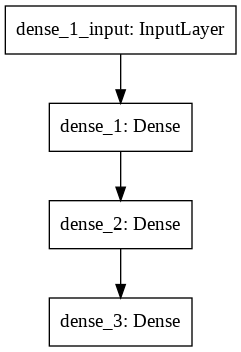

In [35]:
from keras.models import load_model
model = load_model('trainNetworkInEPS999.h5')
model.summary()
from keras.utils import plot_model
plot_model(model, to_file='model.png')